In [1]:
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Lambda,Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.models import Sequential  #用來啟動 NN
from tensorflow.keras.layers import Conv2D  # Convolution Operation
from tensorflow.keras.layers import MaxPooling2D # Pooling
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense # Fully Connected Networks
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate, AveragePooling2D, UpSampling2D, add, Multiply, GlobalAveragePooling2D
import tensorflow.keras as keras  
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import os
import random
import re
import time
from random import shuffle
from matplotlib import pyplot as plt
from scipy.stats import norm
import statistics

In [10]:
def data_collect(Path):
    files=os.listdir(Path)
    Train_Lstm=[]
    Label=[]
    Train=[]
    Train
    count=1
    Train_Pdf=[]
    Time_lists = []
    for file in files:
        start=time.time()
        Break=0
        global Train_pdf, Label_Pdf
        Train_lstm=[]
        file_data=os.listdir(Path+file)
        
        ##CNN_PDF
        #CSFV2
        df_csfv2 = pd.read_csv(Path+file+'/'+file_data[0],header=None)
        df_era5 = pd.read_csv(Path+file+'/'+file_data[1],header=None)
        for column in df_csfv2.columns[2:12]:
            if column == df_csfv2.columns[2]:
                Train_pdf=np.array(np.array(df_csfv2[column]).reshape(61,111,1))
            else:
                Train_pdf=np.append(Train_pdf,np.array(df_csfv2[column]).reshape(61,111,1),axis=2)
                
        #ERAF
        for column in df_era5.columns[2:7]:
            Train_pdf=np.append(Train_pdf,np.array(df_era5[column]).reshape(61,111,1),axis=2)

        ##LSTM
        #ERA5
        df_1 = pd.read_csv(Path+file+'/'+file_data[3])
        for column in df_1.columns[1:91]:
            if' NaN' in list(df_1[column])[:]:
                Break=1
                break
            Train_lstm.append(list(df_1[column]))
            
        #CSFV2
        df_2 = pd.read_csv(Path+file+'/'+file_data[2])
        for column in df_2.columns[1:181]:
            if' NaN' in list(df_2[column])[:]:
                Break=1
                break
            Train_lstm.append(list(df_2[column]))
        if Break==1:
            continue

        ##LABEL_PDF 
        for column in df_era5.columns[7:17]:
            if column == df_era5.columns[7]:
                Label_Pdf=np.array(np.array(df_era5[column]).reshape(61,111,1))
                #print(Label_Pdf)
            else:
                Label_Pdf=np.append(Label_Pdf,np.array(df_era5[column]).reshape(61,111,1),axis=2)

        Train_Pdf.append(Train_pdf)
        Train_Lstm.append(Train_lstm)
        Label.append(Label_Pdf)
        Time_lists.append(file)
        end=time.time()
        Time=(end-start)*(len(files)-count)
        print('%d / %d , Time : %d : %d : %d'%(count,len(files),int(Time/3600),int(Time%3600/60),Time%3600%60),end='\r')
        count=count+1
    Train.append(Train_Pdf)
    Train.append(Train_Lstm)
    Label=np.array(Label)
    return Train, Label, Time_lists

In [11]:
#資料位置
Path='D:/weather/data_180_USA_oneyear/Valid/'
#Path='D:/weather/data_180/Train/'

#載入資料
Valid,Valid_Label,Time_lists=data_collect(Path)

#模型位置
model_path = 'D:/weather/model_usa/LSMT_Restnet_new_data_my_loss_180days_oneyear(test).h5'

#預測CSV儲存位置
Path_perdict_csv = 'D:/weather/Predict_csv/CNN_LSTM_180_USA_oneyear_new/'
if not os.path.exists(Path_perdict_csv):
    os.mkdir(Path_perdict_csv)

In [12]:
Valid_Pdf=Valid[0]
Valid_Lstm=Valid[1]
Valid_Pdf=np.array(Valid_Pdf)
Valid_Lstm=np.array(Valid_Lstm)
print('Valid_Lstm:',Valid_Lstm.shape)
print('Train_Pdf:',Valid_Pdf.shape)

Valid_Lstm: (2745, 270, 10)
Train_Pdf: (2745, 61, 111, 15)


In [13]:
def mcustom_loss(y_true, y_pred):

    trueAvg = (y_true[:,:,:,0][:,:,:,np.newaxis]-Mean[0])/(Max[0]-Min[0])
    trueStd = (y_true[:,:,:,1][:,:,:,np.newaxis]-Mean[1])/(Max[1]-Min[1])
    trueMax = (y_true[:,:,:,2][:,:,:,np.newaxis]-Mean[2])/(Max[2]-Min[2])
    trueMin = (y_true[:,:,:,3][:,:,:,np.newaxis]-Mean[3])/(Max[3]-Min[3])
    trueSkw = (y_true[:,:,:,4][:,:,:,np.newaxis]-Mean[4])/(Max[4]-Min[4])

    predAvg = (y_pred[:,:,:,0][:,:,:,np.newaxis]-Mean[0])/(Max[0]-Min[0])
    predStd = (y_pred[:,:,:,1][:,:,:,np.newaxis]-Mean[1])/(Max[1]-Min[1])
    predMax = (y_pred[:,:,:,2][:,:,:,np.newaxis]-Mean[2])/(Max[2]-Min[2])
    predMin = (y_pred[:,:,:,3][:,:,:,np.newaxis]-Mean[3])/(Max[3]-Min[3])
    predSkw = (y_pred[:,:,:,4][:,:,:,np.newaxis]-Mean[4])/(Max[4]-Min[4])
    
    trueAvg_180 = (y_true[:,:,:,5][:,:,:,np.newaxis]-Mean[5])/(Max[5]-Min[5])
    trueStd_180 = (y_true[:,:,:,6][:,:,:,np.newaxis]-Mean[6])/(Max[6]-Min[6])
    trueMax_180 = (y_true[:,:,:,7][:,:,:,np.newaxis]-Mean[7])/(Max[7]-Min[7])
    trueMin_180 = (y_true[:,:,:,8][:,:,:,np.newaxis]-Mean[8])/(Max[8]-Min[8])
    trueSkw_180 = (y_true[:,:,:,9][:,:,:,np.newaxis]-Mean[9])/(Max[9]-Min[9])

    predAvg_180 = (y_pred[:,:,:,5][:,:,:,np.newaxis]-Mean[5])/(Max[5]-Min[5])
    predStd_180 = (y_pred[:,:,:,6][:,:,:,np.newaxis]-Mean[6])/(Max[6]-Min[6])
    predMax_180 = (y_pred[:,:,:,7][:,:,:,np.newaxis]-Mean[7])/(Max[7]-Min[7])
    predMin_180 = (y_pred[:,:,:,8][:,:,:,np.newaxis]-Mean[8])/(Max[8]-Min[8])
    predSkw_180 = (y_pred[:,:,:,9][:,:,:,np.newaxis]-Mean[9])/(Max[9]-Min[9])

    loss = ((K.square(predMin - trueMin) + K.square(predMax - trueMax) + K.square(predSkw - trueSkw) +
            K.square(predAvg - trueAvg) + K.square(predStd - trueStd))+
            (K.square(predMin_180 - trueMin_180) + K.square(predMax_180 - trueMax_180) + K.square(predSkw_180 - trueSkw_180) +
            K.square(predAvg_180 - trueAvg_180) + K.square(predStd_180 - trueStd_180)))/10
    loss = K.mean(loss, axis=-1)

    return loss

In [14]:
Mean = [285.6935007193419, 3.930768031003403, 293.10764508009817, 276.48751215866434, -0.28795698952502835, 284.47038871812646, 3.5565588572234574, 291.27866058491196, 276.2555687518868, -0.25714618489669394]
Max = [316.0537, 17.9461, 322.4423, 310.6881, 3.7284, 308.8135, 16.3578, 314.0313, 304.951, 2.6613]
Min = [232.2377, 0.1369, 244.5741, 212.2875, -6.5296, 234.7585, 0.1365, 247.8221, 216.693, -5.4746]

In [15]:
from tensorflow import keras
model = load_model(model_path,custom_objects={'mcustom_loss': mcustom_loss})

In [16]:
batchSize=1
y_predict = model.predict([Valid_Pdf,Valid_Lstm],batchSize)

In [17]:
model.evaluate([Valid_Pdf,Valid_Lstm],Valid_Label)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
86/86 [==============================] - 57s 657ms/step - loss: 0.0025


0.0024809478782117367

In [18]:
for day in range(len(y_predict)):
    CSV = []
    for i in range(61):
        for j in range(111):
            CSV_PER = []
            CSV_PER.append(i+1)
            CSV_PER.append(j+1)
            for k in y_predict[day][i][j]:
                CSV_PER.append(k)
            CSV.append(CSV_PER)
    df= pd.DataFrame(CSV,columns=['X','Y','Mean_90','STD_90','Maximum_90','Minimum_90','Skewness_90','Mean_180','STD_180','Maximum_180','Minimum_180','Skewness_180'])
    df.to_csv(Path_perdict_csv+Time_lists[day]+'.csv',index=False)

In [89]:
def PDF_point(i, j, data, start, end, Pic, DATE):
    PDF=[0,0,0,0,0,0,0,0,0,0]
    PDF_csfv2=[0,0,0,0,0,0,0,0,0,0]
    LABEL = ['Mean_90','STD_90','Maximum_90','Minimum_90','Skewness_90','Mean_180','STD_180','Maximum_180','Minimum_180','Skewness_180']
    Era5=[]
    Csfv2=[]
    Predict=[]
    print('第'+str(Pic+1)+'天:',DATE)
    print("Point:",i+1,j+1)
    DATA = []
    for pdf in range(start, end):                
        count=Valid_Label[Pic][i][j][pdf]
        count_data=data[i][j][pdf]
        count_csfv2=Valid_Pdf[Pic][i][j][5+pdf]
        Era5.append(round(count,2))
        Csfv2.append(round(count_csfv2,2))
        Predict.append(round(count_data,2))
        #print(Pic+1,pdf,'ERA5:',round(count,2),"CSFV2:",round(count_csfv2,2),'Predict:',round(count_data,2))
        DATA.append([LABEL[pdf],round(count,2),round(count_csfv2,2),round(count_data,2),round(count,2)-round(count_csfv2,2),round(count,2)-round(count_data,2)])
    df = pd.DataFrame(DATA,columns=['Type','ERA5','CSFV2','Predict','Ori_diff','Pre_deff'])
    print(df)
    Era5_pdf = np.arange(Era5[3],Era5[2],0.1)
    Csfv2_pdf = np.arange(Csfv2[3],Csfv2[2],0.1)
    Predict_pdf = np.arange(Predict[3],Predict[2],0.1)
    plt.plot(Era5_pdf, norm.pdf(Era5_pdf, Era5[0], Era5[1]),label='ERA5' )
    plt.plot(Csfv2_pdf, norm.pdf(Csfv2_pdf, Csfv2[0], Csfv2[1]),label='CSFV2' )
    plt.plot(Predict_pdf, norm.pdf(Predict_pdf, Predict[0], Predict[1]),label='Predict' )
    plt.legend()
    plt.show()    

In [90]:
def PDF_average(data, start, end, Pic, DATE):
    PDF=[0,0,0,0,0,0,0,0,0,0]
    PDF_csfv2=[0,0,0,0,0,0,0,0,0,0]
    LABEL = ['Mean_90','STD_90','Maximum_90','Minimum_90','Skewness_90','Mean_180','STD_180','Maximum_180','Minimum_180','Skewness_180']
    Era5=[]
    Csfv2=[]
    Predict=[]
    print('第'+str(Pic+1)+'天:',DATE)
    DATA = []
    for pdf in range(start,end):
        count=0
        count_data=0
        count_csfv2=0
        for i in range(len(data)):
            for j in range(len(data[0])):
                count=count+Valid_Label[Pic][i][j][pdf]
                count_data=count_data+data[i][j][pdf]
                count_csfv2=count_csfv2+Valid_Pdf[Pic][i][j][5+pdf]
        #print(LABEL[pdf],'ERA5:',round(count/(61*111),2),"CSFV2:",round(count_csfv2/(61*111),2),'Predict:',round(count_data/(61*111),2))
        DATA.append([LABEL[pdf],round(count/(61*111),2),round(count_csfv2/(61*111),2),round(count_data/(61*111),2),round(count/(61*111),2)-round(count_csfv2/(61*111),2),round(count/(61*111),2)-round(count_data/(61*111),2)])
        Era5.append(round(count/(61*111),2))
        Csfv2.append(round(count_csfv2/(61*111),2))
        Predict.append(round(count_data/(61*111),2))
    df = pd.DataFrame(DATA,columns=['Type','ERA5','CSFV2','Predict','Ori_diff','Pre_deff'])
    print(df)
    Era5_pdf = np.arange(Era5[3],Era5[2],0.1)
    Csfv2_pdf = np.arange(Csfv2[3],Csfv2[2],0.1)
    Predict_pdf = np.arange(Predict[3],Predict[2],0.1)
    plt.plot(Era5_pdf, norm.pdf(Era5_pdf, Era5[0], Era5[1]),label='ERA5' )
    plt.plot(Csfv2_pdf, norm.pdf(Csfv2_pdf, Csfv2[0], Csfv2[1]),label='CSFV2' )
    plt.plot(Predict_pdf, norm.pdf(Predict_pdf, Predict[0], Predict[1]),label='Predict' )
    plt.legend()
    plt.show()

In [ ]:
len(data[0])

前90天
第1天: 20120830
Point: 1 1
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  299.86  299.68  300.309998      0.18 -0.449998
1       STD_90    0.45    0.33    0.470000      0.12 -0.020000
2   Maximum_90  300.69  300.36  301.320007      0.33 -0.630007
3   Minimum_90  298.91  298.89  299.200012      0.02 -0.290012
4  Skewness_90   -0.32   -0.59   -0.170000      0.27 -0.150000


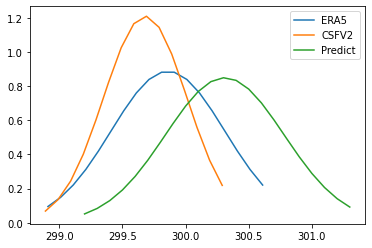

後90天
第1天: 20120830
Point: 1 1
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  299.55  299.86  299.980011     -0.31 -0.430011
1       STD_180    0.34    0.45    0.380000     -0.11 -0.040000
2   Maximum_180  300.20  300.69  300.820007     -0.49 -0.620007
3   Minimum_180  299.02  298.91  299.329987      0.11 -0.309987
4  Skewness_180    0.12   -0.32   -0.450000      0.44  0.570000


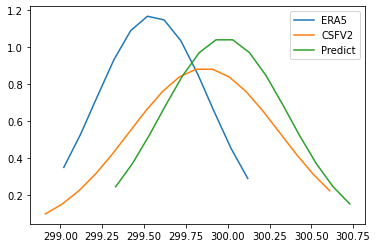

前90天
第1天: 20120830
Point: 1 56
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  273.04  277.94  273.209991     -4.90 -0.169991
1       STD_90    2.74    1.82    4.610000      0.92 -1.870000
2   Maximum_90  277.60  280.91  279.859985     -3.31 -2.259985
3   Minimum_90  265.90  273.40  263.420013     -7.50  2.479987
4  Skewness_90   -0.53   -0.28   -0.310000     -0.25 -0.220000


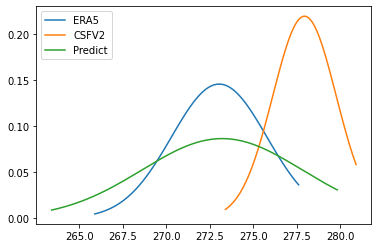

後90天
第1天: 20120830
Point: 1 56
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  260.56  273.04  260.720001    -12.48 -0.160001
1       STD_180    4.66    2.74    4.800000      1.92 -0.140000
2   Maximum_180  270.03  277.60  268.970001     -7.57  1.059999
3   Minimum_180  251.42  265.90  252.729996    -14.48 -1.309996
4  Skewness_180    0.32   -0.53    0.140000      0.85  0.180000


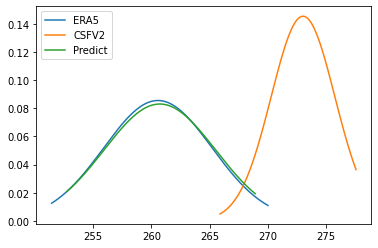

前90天
第1天: 20120830
Point: 1 111
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  276.34  278.73  277.760010     -2.39 -1.420010
1       STD_90    3.25    3.19    3.260000      0.06 -0.010000
2   Maximum_90  280.99  282.91  282.459991     -1.92 -1.469991
3   Minimum_90  266.85  272.16  268.859985     -5.31 -2.009985
4  Skewness_90   -0.80   -0.58   -0.700000     -0.22 -0.100000


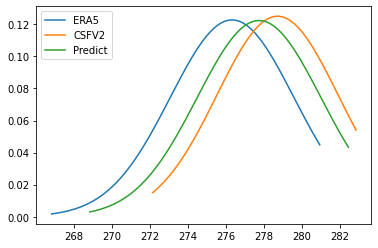

後90天
第1天: 20120830
Point: 1 111
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  268.57  276.34  268.239990     -7.77  0.330010
1       STD_180    3.91    3.25    4.580000      0.66 -0.670000
2   Maximum_180  275.86  280.99  275.799988     -5.13  0.060012
3   Minimum_180  261.23  266.85  259.750000     -5.62  1.480000
4  Skewness_180   -0.15   -0.80    0.020000      0.65 -0.170000


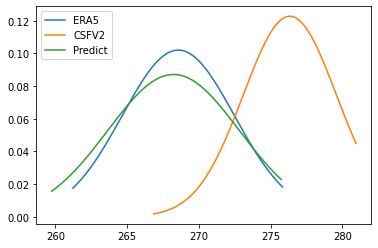

前90天
第1天: 20120830
Point: 31 1
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  283.09  292.19  283.790009     -9.10 -0.700009
1       STD_90    6.34    4.55    6.160000      1.79  0.180000
2   Maximum_90  293.97  298.71  295.760010     -4.74 -1.790010
3   Minimum_90  270.35  280.18  270.709991     -9.83 -0.359991
4  Skewness_90   -0.19   -0.65    0.040000      0.46 -0.230000


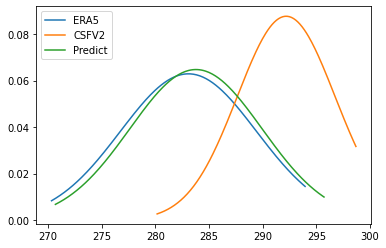

後90天
第1天: 20120830
Point: 31 1
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  273.28  283.09  274.450012     -9.81 -1.170012
1       STD_180    4.15    6.34    3.650000     -2.19  0.500000
2   Maximum_180  280.88  293.97  281.109985    -13.09 -0.229985
3   Minimum_180  265.53  270.35  266.609985     -4.82 -1.079985
4  Skewness_180    0.00   -0.19    0.010000      0.19 -0.010000


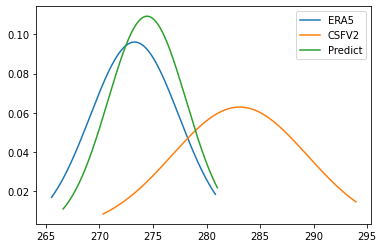

前90天
第1天: 20120830
Point: 31 56
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  284.10  295.51  284.429993    -11.41 -0.329993
1       STD_90    7.40    3.89    6.830000      3.51  0.570000
2   Maximum_90  295.42  301.55  295.739990     -6.13 -0.319990
3   Minimum_90  263.38  278.81  269.010010    -15.43 -5.630010
4  Skewness_90   -0.59   -1.85    0.110000      1.26 -0.700000


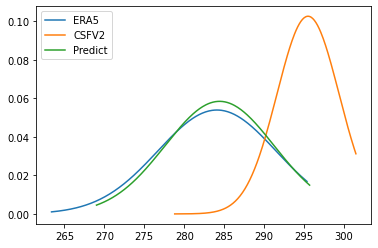

後90天
第1天: 20120830
Point: 31 56
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  271.43  284.10  273.200012    -12.67 -1.770012
1       STD_180    6.19    7.40    4.550000     -1.21  1.640000
2   Maximum_180  280.86  295.42  280.239990    -14.56  0.620010
3   Minimum_180  257.89  263.38  262.260010     -5.49 -4.370010
4  Skewness_180   -0.64   -0.59   -0.030000     -0.05 -0.610000


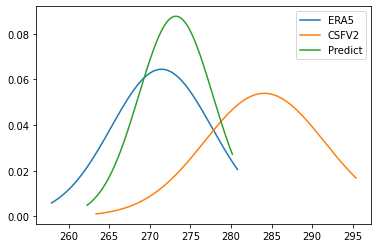

前90天
第1天: 20120830
Point: 31 111
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  298.30  306.69  297.750000     -8.39  0.550000
1       STD_90    6.41    2.80    6.910000      3.61 -0.500000
2   Maximum_90  308.29  311.70  308.609985     -3.41 -0.319985
3   Minimum_90  284.15  299.18  285.029999    -15.03 -0.879999
4  Skewness_90   -0.20   -0.33   -0.210000      0.13  0.010000


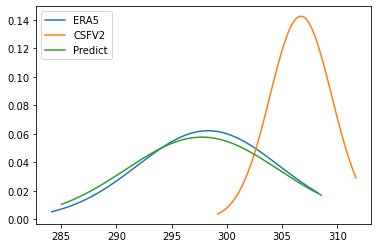

後90天
第1天: 20120830
Point: 31 111
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  285.81  298.30  287.760010    -12.49 -1.950010
1       STD_180    3.92    6.41    2.890000     -2.49  1.030000
2   Maximum_180  291.54  308.29  291.350006    -16.75  0.189994
3   Minimum_180  279.11  284.15  282.309998     -5.04 -3.199998
4  Skewness_180    0.17   -0.20   -0.470000      0.37  0.640000


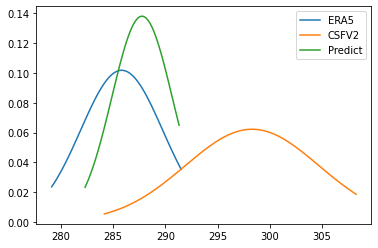

前90天
第1天: 20120830
Point: 61 1
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  300.15  300.48  300.720001     -0.33 -0.570001
1       STD_90    0.66    0.53    0.800000      0.13 -0.140000
2   Maximum_90  301.29  301.37  301.769989     -0.08 -0.479989
3   Minimum_90  298.48  298.90  298.929993     -0.42 -0.449993
4  Skewness_90   -0.17   -0.81   -0.240000      0.64  0.070000


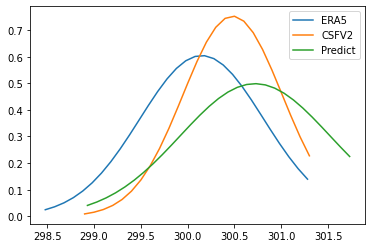

後90天
第1天: 20120830
Point: 61 1
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  298.03  300.15  298.890015     -2.12 -0.860015
1       STD_180    0.55    0.66    0.750000     -0.11 -0.200000
2   Maximum_180  299.05  301.29  299.869995     -2.24 -0.819995
3   Minimum_180  296.77  298.48  297.839996     -1.71 -1.069996
4  Skewness_180   -0.77   -0.17   -0.250000     -0.60 -0.520000


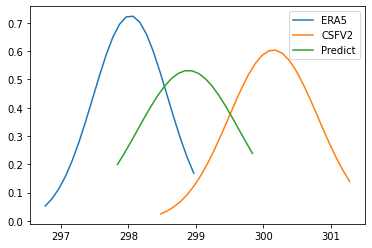

前90天
第1天: 20120830
Point: 61 56
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  300.59  300.31  300.950012      0.28 -0.360012
1       STD_90    0.48    0.44    0.750000      0.04 -0.270000
2   Maximum_90  301.87  301.21  302.519989      0.66 -0.649989
3   Minimum_90  299.24  298.98  299.619995      0.26 -0.379995
4  Skewness_90   -0.23   -0.62   -0.120000      0.39 -0.110000


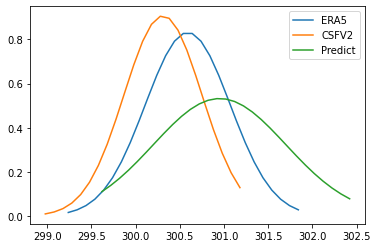

後90天
第1天: 20120830
Point: 61 56
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  299.54  300.59  300.279999     -1.05 -0.739999
1       STD_180    0.44    0.48    0.330000     -0.04  0.110000
2   Maximum_180  300.20  301.87  300.910004     -1.67 -0.710004
3   Minimum_180  298.41  299.24  299.369995     -0.83 -0.959995
4  Skewness_180   -0.73   -0.23   -0.120000     -0.50 -0.610000


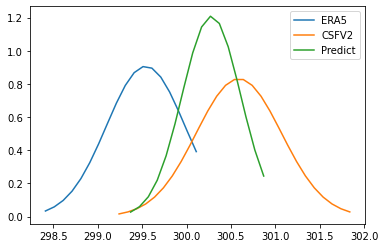

前90天
第1天: 20120830
Point: 61 111
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  273.36  276.66  272.380005     -3.30  0.979995
1       STD_90    3.88    2.41    4.990000      1.47 -1.110000
2   Maximum_90  279.32  280.33  278.660004     -1.01  0.659996
3   Minimum_90  263.69  271.82  259.980011     -8.13  3.709989
4  Skewness_90   -0.48   -0.36   -0.670000     -0.12  0.190000


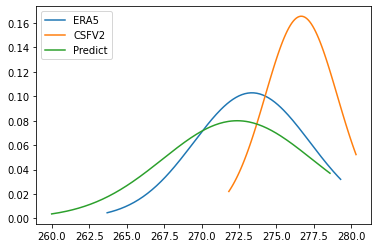

後90天
第1天: 20120830
Point: 61 111
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  260.21  273.36  258.839996    -13.15  1.370004
1       STD_180    4.13    3.88    4.390000      0.25 -0.260000
2   Maximum_180  268.41  279.32  267.279999    -10.91  1.130001
3   Minimum_180  254.65  263.69  250.449997     -9.04  4.200003
4  Skewness_180    0.60   -0.48   -0.070000      1.08  0.670000


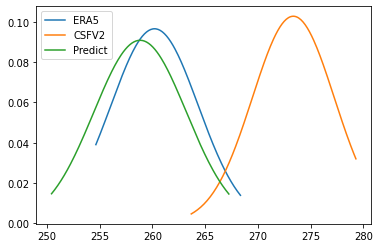

前90天
第916天: 20150303
Point: 1 1
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  299.79  299.50  299.459991      0.29  0.330009
1       STD_90    0.42    0.31    0.380000      0.11  0.040000
2   Maximum_90  300.82  300.22  300.239990      0.60  0.580010
3   Minimum_90  299.02  298.59  298.260010      0.43  0.759990
4  Skewness_90    0.23   -0.33   -0.950000      0.56  1.180000


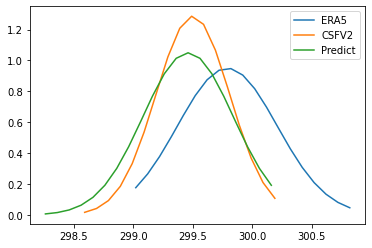

後90天
第916天: 20150303
Point: 1 1
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  300.39  299.79  299.500000      0.60  0.890000
1       STD_180    0.29    0.42    0.400000     -0.13 -0.110000
2   Maximum_180  300.87  300.82  300.309998      0.05  0.560002
3   Minimum_180  299.85  299.02  298.890015      0.83  0.959985
4  Skewness_180    0.02    0.23   -0.980000     -0.21  1.000000


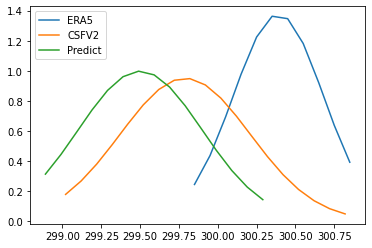

前90天
第916天: 20150303
Point: 1 56
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  265.91  262.43  263.910004      3.48  1.999996
1       STD_90    7.68    6.33    6.820000      1.35  0.860000
2   Maximum_90  276.56  272.73  275.070007      3.83  1.489993
3   Minimum_90  250.99  251.26  251.669998     -0.27 -0.679998
4  Skewness_90   -0.35   -0.16   -0.290000     -0.19 -0.060000


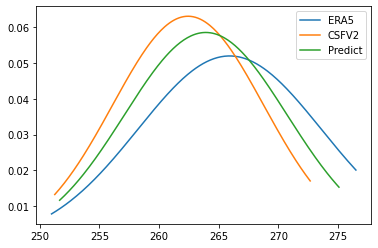

後90天
第916天: 20150303
Point: 1 56
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  277.40  265.91  274.869995     11.49  2.530005
1       STD_180    1.98    7.68    2.200000     -5.70 -0.220000
2   Maximum_180  280.15  276.56  277.679993      3.59  2.470007
3   Minimum_180  273.54  250.99  271.059998     22.55  2.480002
4  Skewness_180   -0.16   -0.35    0.090000      0.19 -0.250000


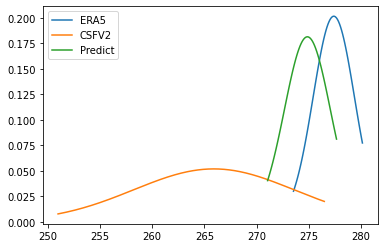

前90天
第916天: 20150303
Point: 1 111
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  270.09  270.94  267.829987     -0.85  2.260013
1       STD_90    4.63    4.06    5.040000      0.57 -0.410000
2   Maximum_90  277.09  277.22  275.489990     -0.13  1.600010
3   Minimum_90  260.25  260.88  256.660004     -0.63  3.589996
4  Skewness_90   -0.39   -0.82   -0.590000      0.43  0.200000


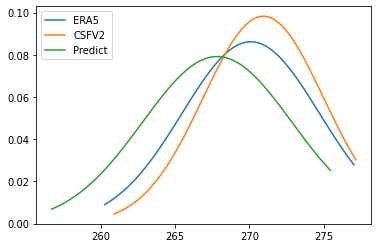

後90天
第916天: 20150303
Point: 1 111
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  278.13  270.09  275.989990      8.04  2.140010
1       STD_180    1.80    4.63    1.960000     -2.83 -0.160000
2   Maximum_180  282.00  277.09  278.369995      4.91  3.630005
3   Minimum_180  275.34  260.25  272.410004     15.09  2.929996
4  Skewness_180    0.31   -0.39   -0.020000      0.70  0.330000


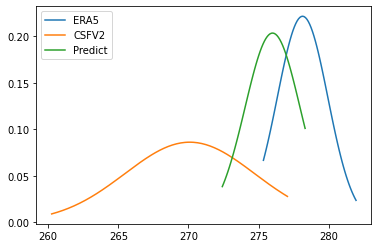

前90天
第916天: 20150303
Point: 31 1
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  283.27  274.83  281.109985      8.44  2.160015
1       STD_90    3.97    4.98    4.590000     -1.01 -0.620000
2   Maximum_90  292.60  283.62  292.209991      8.98  0.390009
3   Minimum_90  275.02  255.53  272.269989     19.49  2.750011
4  Skewness_90   -0.05   -1.56    0.370000      1.51 -0.420000


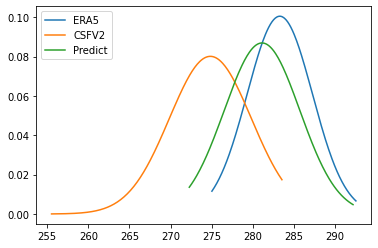

後90天
第916天: 20150303
Point: 31 1
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  294.86  283.27  289.839996     11.59  5.020004
1       STD_180    3.78    3.97    3.100000     -0.19  0.680000
2   Maximum_180  301.62  292.60  295.899994      9.02  5.720006
3   Minimum_180  287.37  275.02  283.260010     12.35  4.109990
4  Skewness_180    0.06   -0.05    0.210000      0.11 -0.150000


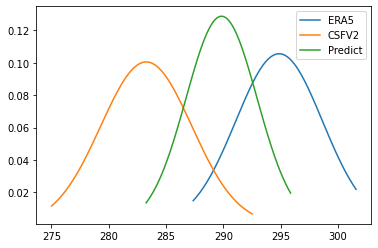

前90天
第916天: 20150303
Point: 31 56
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  282.91  273.53  281.279999      9.38  1.630001
1       STD_90    4.37    5.21    7.120000     -0.84 -2.750000
2   Maximum_90  293.83  283.57  294.730011     10.26 -0.900011
3   Minimum_90  271.03  257.30  265.890015     13.73  5.139985
4  Skewness_90    0.01   -0.76    0.140000      0.77 -0.130000


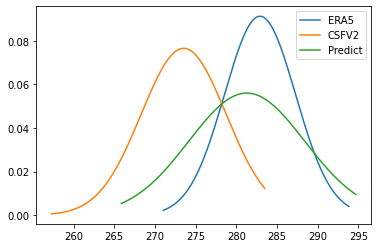

後90天
第916天: 20150303
Point: 31 56
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  296.70  282.91  293.149994     13.79  3.550006
1       STD_180    3.66    4.37    3.740000     -0.71 -0.080000
2   Maximum_180  302.06  293.83  299.230011      8.23  2.829989
3   Minimum_180  286.93  271.03  285.559998     15.90  1.370002
4  Skewness_180   -0.79    0.01    0.260000     -0.80 -1.050000


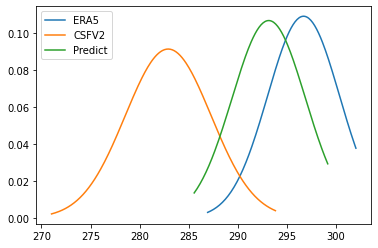

前90天
第916天: 20150303
Point: 31 111
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  297.47  287.65  297.119995      9.82  0.350005
1       STD_90    3.75    3.86    6.080000     -0.11 -2.330000
2   Maximum_90  306.48  294.14  307.299988     12.34 -0.819988
3   Minimum_90  288.72  275.99  284.410004     12.73  4.309996
4  Skewness_90    0.09   -0.72   -0.280000      0.81  0.370000


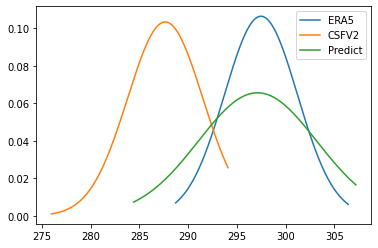

後90天
第916天: 20150303
Point: 31 111
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  307.78  297.47  305.950012     10.31  1.829988
1       STD_180    2.64    3.75    3.160000     -1.11 -0.520000
2   Maximum_180  311.49  306.48  310.119995      5.01  1.370005
3   Minimum_180  299.56  288.72  298.510010     10.84  1.049990
4  Skewness_180   -1.22    0.09   -0.790000     -1.31 -0.430000


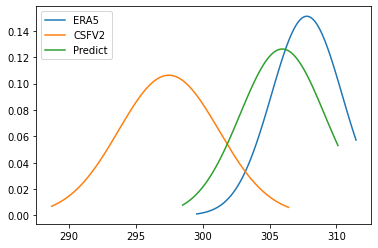

前90天
第916天: 20150303
Point: 61 1
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  298.06  297.81  297.959991      0.25  0.100009
1       STD_90    0.79    0.48    1.150000      0.31 -0.360000
2   Maximum_90  299.66  298.99  299.779999      0.67 -0.119999
3   Minimum_90  296.42  296.45  295.529999     -0.03  0.890001
4  Skewness_90    0.00   -0.29   -0.020000      0.29  0.020000


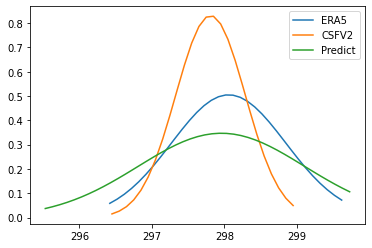

後90天
第916天: 20150303
Point: 61 1
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  299.71  298.06  299.750000      1.65 -0.040000
1       STD_180    0.30    0.79    0.640000     -0.49 -0.340000
2   Maximum_180  300.33  299.66  300.649994      0.67 -0.319994
3   Minimum_180  299.03  296.42  298.559998      2.61  0.470002
4  Skewness_180   -0.54    0.00   -0.800000     -0.54  0.260000


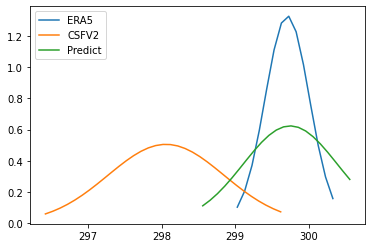

前90天
第916天: 20150303
Point: 61 56
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  298.95  298.79  299.049988      0.16 -0.099988
1       STD_90    0.64    0.48    0.780000      0.16 -0.140000
2   Maximum_90  300.08  299.87  300.570007      0.21 -0.490007
3   Minimum_90  297.31  297.44  297.459991     -0.13 -0.149991
4  Skewness_90   -0.16   -0.12    0.210000     -0.04 -0.370000


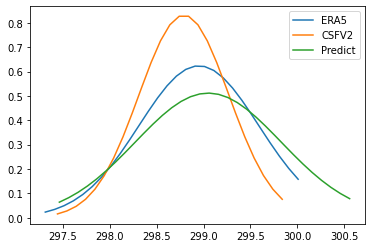

後90天
第916天: 20150303
Point: 61 56
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  299.67  298.95  300.160004      0.72 -0.490004
1       STD_180    0.23    0.64    0.330000     -0.41 -0.100000
2   Maximum_180  300.04  300.08  300.820007     -0.04 -0.780007
3   Minimum_180  299.06  297.31  299.130005      1.75 -0.070005
4  Skewness_180   -0.72   -0.16   -0.410000     -0.56 -0.310000


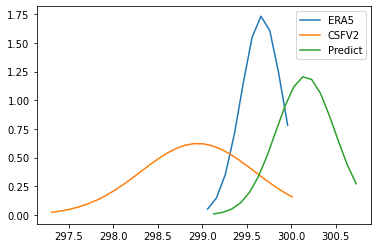

前90天
第916天: 20150303
Point: 61 111
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  260.31  250.39  260.220001      9.92  0.089999
1       STD_90    7.66    3.72    8.140000      3.94 -0.480000
2   Maximum_90  272.11  260.94  272.059998     11.17  0.050002
3   Minimum_90  247.34  245.05  244.940002      2.29  2.399998
4  Skewness_90    0.09    0.77   -0.270000     -0.68  0.360000


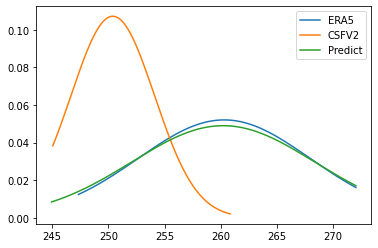

後90天
第916天: 20150303
Point: 61 111
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  273.68  260.31  273.450012     13.37  0.229988
1       STD_180    0.95    7.66    1.900000     -6.71 -0.950000
2   Maximum_180  275.31  272.11  276.519989      3.20 -1.209989
3   Minimum_180  271.71  247.34  269.519989     24.37  2.190011
4  Skewness_180   -0.13    0.09   -0.070000     -0.22 -0.060000


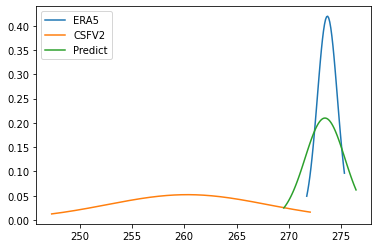

前90天
第1831天: 20170903
Point: 1 1
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  299.43  299.88  298.390015     -0.45  1.039985
1       STD_90    0.44    0.41    0.290000      0.03  0.150000
2   Maximum_90  300.56  300.91  299.179993     -0.35  1.380007
3   Minimum_90  298.49  298.96  296.529999     -0.47  1.960001
4  Skewness_90    0.10    0.08   -0.410000      0.02  0.510000


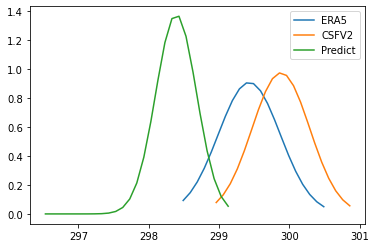

後90天
第1831天: 20170903
Point: 1 1
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  299.41  299.43  298.200012     -0.02  1.209988
1       STD_180    0.51    0.44    0.470000      0.07  0.040000
2   Maximum_180  300.33  300.56  298.880005     -0.23  1.449995
3   Minimum_180  298.09  298.49  297.170013     -0.40  0.919987
4  Skewness_180   -0.19    0.10   -0.950000     -0.29  0.760000


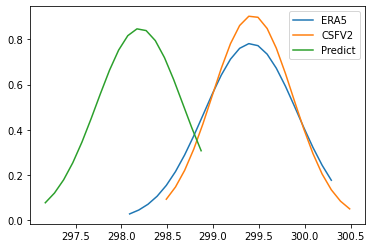

前90天
第1831天: 20170903
Point: 1 56
          Type    ERA5   CSFV2     Predict  Ori_diff   Pre_deff
0      Mean_90  267.76  275.65  256.649994     -7.89  11.110006
1       STD_90    5.73    2.59    7.580000      3.14  -1.850000
2   Maximum_90  274.66  279.40  270.809998     -4.74   3.850002
3   Minimum_90  252.07  267.71  243.320007    -15.64   8.749993
4  Skewness_90   -1.26   -0.84    0.180000     -0.42  -1.440000


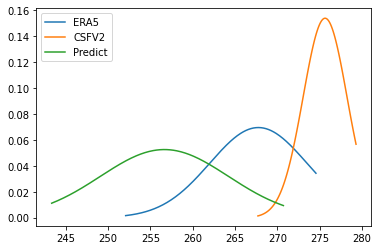

後90天
第1831天: 20170903
Point: 1 56
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  263.40  267.76  255.720001     -4.36  7.679999
1       STD_180    6.62    5.73    4.770000      0.89  1.850000
2   Maximum_180  272.31  274.66  265.459991     -2.35  6.850009
3   Minimum_180  251.01  252.07  248.050003     -1.06  2.959997
4  Skewness_180   -0.22   -1.26    0.790000      1.04 -1.010000


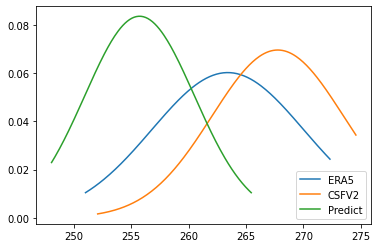

前90天
第1831天: 20170903
Point: 1 111
          Type    ERA5   CSFV2     Predict  Ori_diff   Pre_deff
0      Mean_90  273.46  279.01  265.000000     -5.55   8.460000
1       STD_90    2.53    2.12    6.970000      0.41  -4.440000
2   Maximum_90  277.48  281.79  275.160004     -4.31   2.319996
3   Minimum_90  265.84  273.13  250.429993     -7.29  15.410007
4  Skewness_90   -1.34   -0.66   -0.300000     -0.68  -1.040000


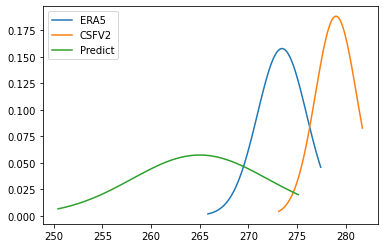

後90天
第1831天: 20170903
Point: 1 111
           Type    ERA5   CSFV2     Predict  Ori_diff   Pre_deff
0      Mean_180  273.12  273.46  262.529999     -0.34  10.590001
1       STD_180    1.93    2.53    5.410000     -0.60  -3.480000
2   Maximum_180  275.35  277.48  270.730011     -2.13   4.619989
3   Minimum_180  268.40  265.84  253.490005      2.56  14.909995
4  Skewness_180   -0.95   -1.34    0.180000      0.39  -1.130000


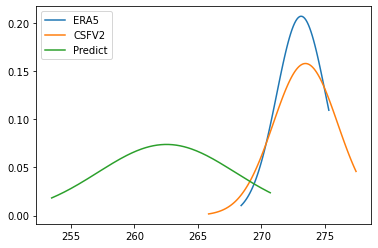

前90天
第1831天: 20170903
Point: 31 1
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  272.92  282.89  272.869995     -9.97  0.050005
1       STD_90    4.28    7.10    2.480000     -2.82  1.800000
2   Maximum_90  280.83  298.08  281.940002    -17.25 -1.110002
3   Minimum_90  257.46  271.60  264.640015    -14.14 -7.180015
4  Skewness_90   -1.01    0.70    0.100000     -1.71 -1.110000


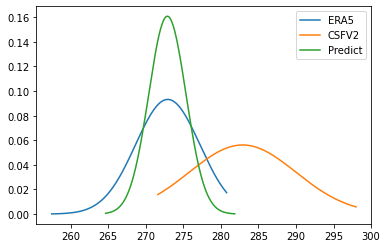

後90天
第1831天: 20170903
Point: 31 1
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  274.42  272.92  274.429993      1.50 -0.009993
1       STD_180    4.36    4.28    2.940000      0.08  1.420000
2   Maximum_180  281.42  280.83  280.709991      0.59  0.710009
3   Minimum_180  264.73  257.46  268.450012      7.27 -3.720012
4  Skewness_180   -0.49   -1.01    0.210000      0.52 -0.700000


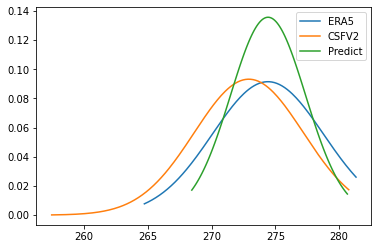

前90天
第1831天: 20170903
Point: 31 56
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  272.94  283.71  270.220001    -10.77  2.719999
1       STD_90    4.02    7.11    3.740000     -3.09  0.280000
2   Maximum_90  283.04  298.87  280.880005    -15.83  2.159995
3   Minimum_90  262.75  270.26  258.000000     -7.51  4.750000
4  Skewness_90   -0.20    0.66    0.330000     -0.86 -0.530000


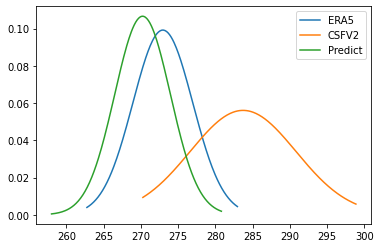

後90天
第1831天: 20170903
Point: 31 56
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  270.06  272.94  271.959991     -2.88 -1.899991
1       STD_180    5.57    4.02    5.060000      1.55  0.510000
2   Maximum_180  280.01  283.04  280.799988     -3.03 -0.789988
3   Minimum_180  257.21  262.75  262.119995     -5.54 -4.909995
4  Skewness_180   -0.30   -0.20    0.400000     -0.10 -0.700000


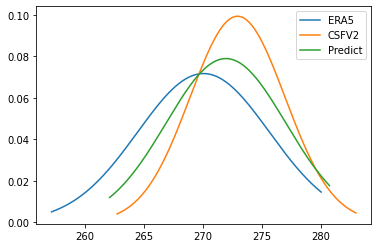

前90天
第1831天: 20170903
Point: 31 111
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  287.54  298.78  285.380005    -11.24  2.159995
1       STD_90    3.06    5.43    3.210000     -2.37 -0.150000
2   Maximum_90  293.72  311.46  294.649994    -17.74 -0.929994
3   Minimum_90  279.94  287.33  278.279999     -7.39  1.660001
4  Skewness_90   -0.21    0.56    0.260000     -0.77 -0.470000


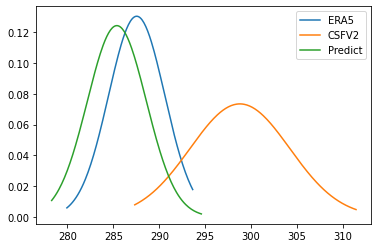

後90天
第1831天: 20170903
Point: 31 111
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  289.40  287.54  289.350006      1.86  0.049994
1       STD_180    4.26    3.06    3.430000      1.20  0.830000
2   Maximum_180  296.74  293.72  294.549988      3.02  2.190012
3   Minimum_180  281.67  279.94  283.000000      1.73 -1.330000
4  Skewness_180   -0.12   -0.21   -0.370000      0.09  0.250000


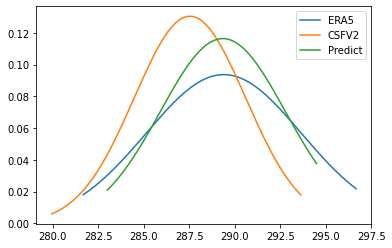

前90天
第1831天: 20170903
Point: 61 1
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  297.85  299.98  296.589996     -2.13  1.260004
1       STD_90    0.85    0.69    0.710000      0.16  0.140000
2   Maximum_90  299.57  301.39  298.170013     -1.82  1.399987
3   Minimum_90  296.13  298.30  295.049988     -2.17  1.080012
4  Skewness_90   -0.02   -0.24   -0.140000      0.22  0.120000


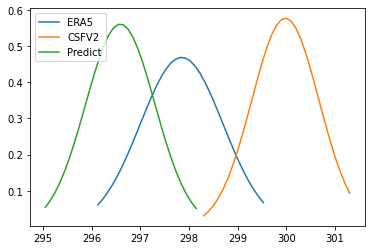

後90天
第1831天: 20170903
Point: 61 1
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  297.23  297.85  296.109985     -0.62  1.120015
1       STD_180    0.73    0.85    0.820000     -0.12 -0.090000
2   Maximum_180  298.20  299.57  297.239990     -1.37  0.960010
3   Minimum_180  295.46  296.13  294.769989     -0.67  0.690011
4  Skewness_180   -0.77   -0.02   -0.400000     -0.75 -0.370000


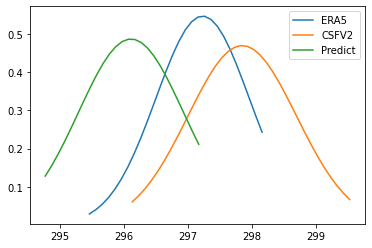

前90天
第1831天: 20170903
Point: 61 56
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  298.95  300.44  298.109985     -1.49  0.840015
1       STD_90    0.71    0.51    0.610000      0.20  0.100000
2   Maximum_90  300.39  301.71  299.049988     -1.32  1.340012
3   Minimum_90  297.22  298.77  296.970001     -1.55  0.249999
4  Skewness_90   -0.04   -0.43    0.480000      0.39 -0.520000


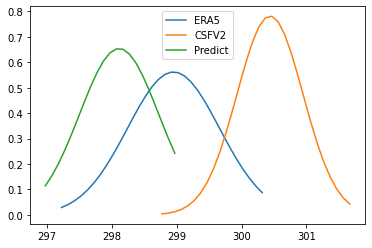

後90天
第1831天: 20170903
Point: 61 56
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  298.33  298.95  297.429993     -0.62  0.900007
1       STD_180    0.50    0.71    0.270000     -0.21  0.230000
2   Maximum_180  299.06  300.39  298.269989     -1.33  0.790011
3   Minimum_180  297.12  297.22  296.730011     -0.10  0.389989
4  Skewness_180   -0.69   -0.04   -0.560000     -0.65 -0.130000


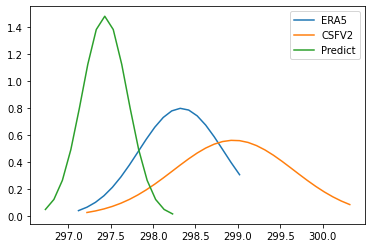

前90天
第1831天: 20170903
Point: 61 111
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  253.03  271.59  252.889999    -18.56  0.140001
1       STD_90    9.28    4.78    7.390000      4.50  1.890000
2   Maximum_90  273.44  278.70  266.709991     -5.26  6.730009
3   Minimum_90  241.29  258.66  238.429993    -17.37  2.860007
4  Skewness_90    0.90   -0.93    0.190000      1.83  0.710000


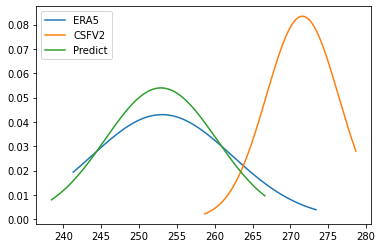

後90天
第1831天: 20170903
Point: 61 111
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  251.17  253.03  250.550003     -1.86  0.619997
1       STD_180    5.51    9.28    4.410000     -3.77  1.100000
2   Maximum_180  262.85  273.44  259.049988    -10.59  3.800012
3   Minimum_180  242.74  241.29  242.600006      1.45  0.139994
4  Skewness_180    0.74    0.90    0.160000     -0.16  0.580000


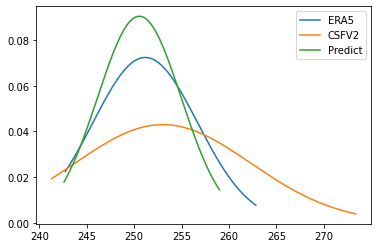

前90天
第2745天: 20200305
Point: 1 1
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  299.94  299.80  299.040009      0.14  0.899991
1       STD_90    0.42    0.32    0.320000      0.10  0.100000
2   Maximum_90  300.73  300.45  299.779999      0.28  0.950001
3   Minimum_90  299.10  298.92  298.109985      0.18  0.990015
4  Skewness_90   -0.23   -0.62   -0.660000      0.39  0.430000


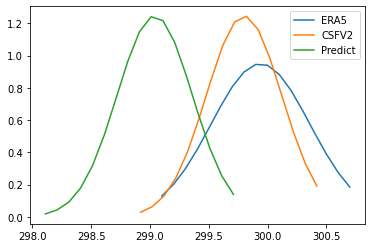

後90天
第2745天: 20200305
Point: 1 1
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  299.97  299.94  299.320007      0.03  0.649993
1       STD_180    0.48    0.42    0.450000      0.06  0.030000
2   Maximum_180  300.91  300.73  299.970001      0.18  0.939999
3   Minimum_180  299.14  299.10  298.200012      0.04  0.939988
4  Skewness_180    0.31   -0.23   -0.540000      0.54  0.850000


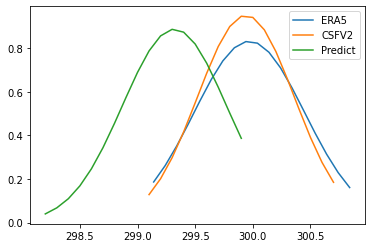

前90天
第2745天: 20200305
Point: 1 56
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  278.14  267.53  277.250000     10.61  0.890000
1       STD_90    1.68    5.76    3.030000     -4.08 -1.350000
2   Maximum_90  282.03  275.13  280.649994      6.90  1.380006
3   Minimum_90  273.48  250.85  271.959991     22.63  1.520009
4  Skewness_90   -0.57   -0.99   -0.320000      0.42 -0.250000


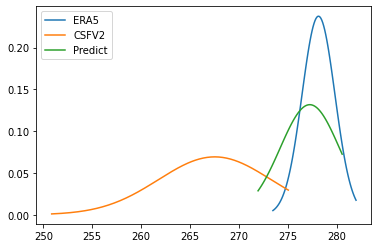

後90天
第2745天: 20200305
Point: 1 56
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  278.25  278.14  276.750000      0.11  1.500000
1       STD_180    1.29    1.68    1.480000     -0.39 -0.190000
2   Maximum_180  280.53  282.03  278.869995     -1.50  1.660005
3   Minimum_180  275.67  273.48  274.630005      2.19  1.039995
4  Skewness_180   -0.53   -0.57    0.200000      0.04 -0.730000


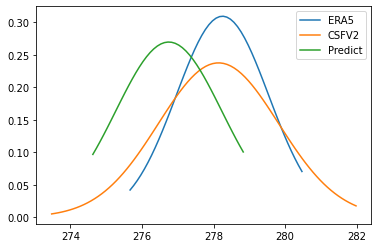

前90天
第2745天: 20200305
Point: 1 111
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  281.06  272.06  278.220001      9.00  2.839999
1       STD_90    2.31    3.89    2.920000     -1.58 -0.610000
2   Maximum_90  284.65  278.57  282.109985      6.08  2.540015
3   Minimum_90  276.34  258.17  272.829987     18.17  3.510013
4  Skewness_90   -0.32   -1.67   -0.510000      1.35  0.190000


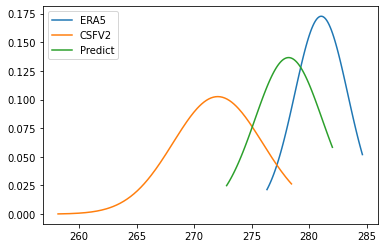

後90天
第2745天: 20200305
Point: 1 111
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  282.27  281.06  279.420013      1.21  2.849987
1       STD_180    1.31    2.31    1.560000     -1.00 -0.250000
2   Maximum_180  284.40  284.65  280.989990     -0.25  3.410010
3   Minimum_180  279.04  276.34  276.929993      2.70  2.110007
4  Skewness_180   -0.78   -0.32   -0.230000     -0.46 -0.550000


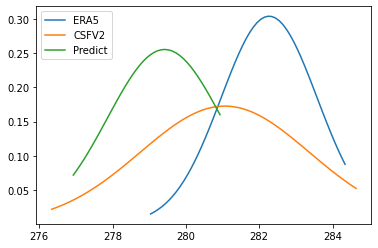

前90天
第2745天: 20200305
Point: 31 1
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  291.24  280.99  291.700012     10.25 -0.460012
1       STD_90    4.51    4.72    4.000000     -0.21  0.510000
2   Maximum_90  300.55  295.16  299.309998      5.39  1.240002
3   Minimum_90  280.12  272.10  280.540009      8.02 -0.420009
4  Skewness_90   -0.42    0.38   -0.340000     -0.80 -0.080000


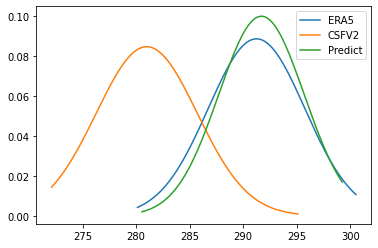

後90天
第2745天: 20200305
Point: 31 1
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  289.51  291.24  288.510010     -1.73  0.999990
1       STD_180    3.51    4.51    3.010000     -1.00  0.500000
2   Maximum_180  296.06  300.55  294.239990     -4.49  1.820010
3   Minimum_180  282.26  280.12  280.470001      2.14  1.789999
4  Skewness_180   -0.12   -0.42   -0.420000      0.30  0.300000


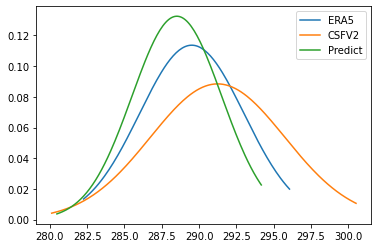

前90天
第2745天: 20200305
Point: 31 56
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  295.78  281.32  295.119995     14.46  0.660005
1       STD_90    4.76    6.72    3.580000     -1.96  1.180000
2   Maximum_90  301.56  298.32  301.980011      3.24 -0.420011
3   Minimum_90  277.36  268.55  282.070007      8.81 -4.710007
4  Skewness_90   -1.75    0.44   -0.610000     -2.19 -1.140000


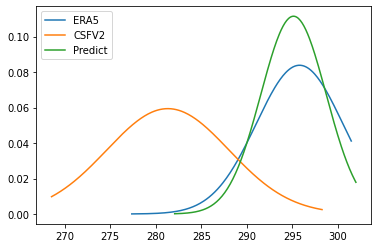

後90天
第2745天: 20200305
Point: 31 56
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  292.15  295.78  290.690002     -3.63  1.459998
1       STD_180    4.58    4.76    2.920000     -0.18  1.660000
2   Maximum_180  300.34  301.56  295.380005     -1.22  4.959995
3   Minimum_180  281.82  277.36  283.350006      4.46 -1.530006
4  Skewness_180   -0.35   -1.75   -0.040000      1.40 -0.310000


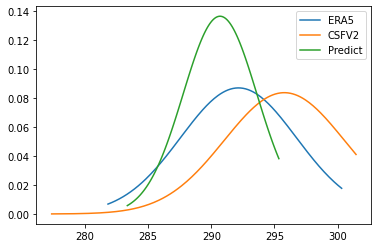

前90天
第2745天: 20200305
Point: 31 111
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  308.78  296.47  306.750000     12.31  2.030000
1       STD_90    3.23    6.40    3.270000     -3.17 -0.040000
2   Maximum_90  314.00  308.77  312.260010      5.23  1.739990
3   Minimum_90  298.65  284.73  296.309998     13.92  2.340002
4  Skewness_90   -0.94    0.17   -0.810000     -1.11 -0.130000


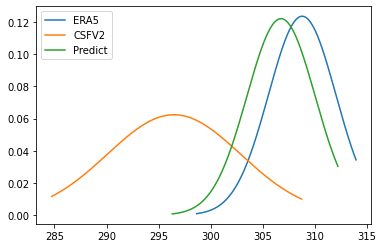

後90天
第2745天: 20200305
Point: 31 111
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  306.15  308.78  303.089996     -2.63  3.060004
1       STD_180    3.24    3.23    3.180000      0.01  0.060000
2   Maximum_180  312.81  314.00  307.140015     -1.19  5.669985
3   Minimum_180  299.00  298.65  296.380005      0.35  2.619995
4  Skewness_180   -0.36   -0.94   -0.880000      0.58  0.520000


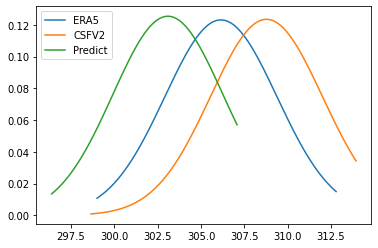

前90天
第2745天: 20200305
Point: 61 1
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  300.39  298.03  299.700012      2.36  0.689988
1       STD_90    0.49    1.01    0.770000     -0.52 -0.280000
2   Maximum_90  301.24  299.92  300.880005      1.32  0.359995
3   Minimum_90  299.25  295.82  297.829987      3.43  1.420013
4  Skewness_90   -0.34   -0.38   -0.740000      0.04  0.400000


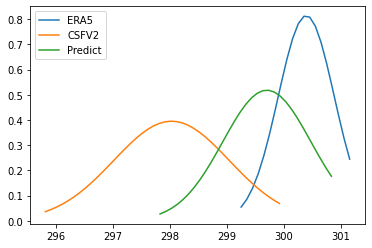

後90天
第2745天: 20200305
Point: 61 1
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  300.67  300.39  300.160004      0.28  0.509996
1       STD_180    0.45    0.49    0.610000     -0.04 -0.160000
2   Maximum_180  301.46  301.24  301.040009      0.22  0.419991
3   Minimum_180  299.84  299.25  299.010010      0.59  0.829990
4  Skewness_180   -0.30   -0.34   -0.650000      0.04  0.350000


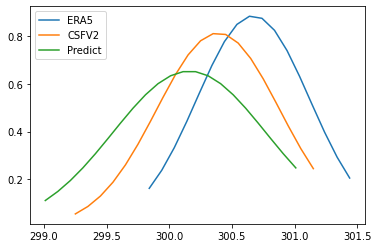

前90天
第2745天: 20200305
Point: 61 56
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  300.60  299.29  299.899994      1.31  0.700006
1       STD_90    0.48    0.69    0.590000     -0.21 -0.110000
2   Maximum_90  301.58  300.71  300.690002      0.87  0.889998
3   Minimum_90  299.30  297.67  298.410004      1.63  0.889996
4  Skewness_90   -0.41   -0.11   -0.520000     -0.30  0.110000


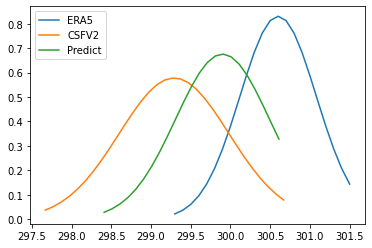

後90天
第2745天: 20200305
Point: 61 56
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  300.79  300.60  300.029999      0.19  0.760001
1       STD_180    0.65    0.48    0.360000      0.17  0.290000
2   Maximum_180  301.91  301.58  301.119995      0.33  0.790005
3   Minimum_180  299.68  299.30  299.019989      0.38  0.660011
4  Skewness_180   -0.24   -0.41   -0.350000      0.17  0.110000


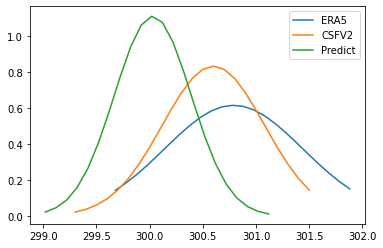

前90天
第2745天: 20200305
Point: 61 111
          Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_90  275.96  260.96  276.910004     15.00 -0.950004
1       STD_90    3.02    9.31    2.960000     -6.29  0.060000
2   Maximum_90  280.82  274.18  280.230011      6.64  0.589989
3   Minimum_90  271.00  240.72  270.600006     30.28  0.399994
4  Skewness_90   -0.15   -0.65   -0.480000      0.50  0.330000


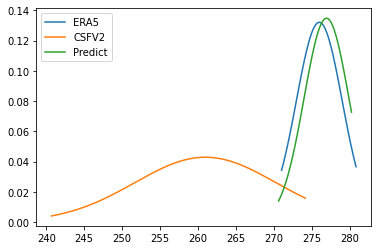

後90天
第2745天: 20200305
Point: 61 111
           Type    ERA5   CSFV2     Predict  Ori_diff  Pre_deff
0      Mean_180  276.49  275.96  277.480011      0.53 -0.990011
1       STD_180    1.51    3.02    0.610000     -1.51  0.900000
2   Maximum_180  278.89  280.82  279.190002     -1.93 -0.300002
3   Minimum_180  273.88  271.00  275.369995      2.88 -1.489995
4  Skewness_180    0.04   -0.15    0.090000      0.19 -0.050000


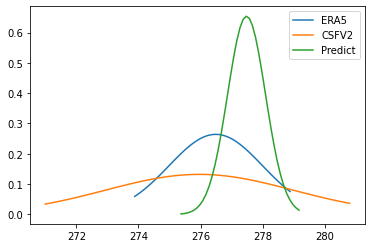

In [91]:
#單點作圖PDF
Pic=0
for data in y_predict:
    if Pic == 0 or Pic == int(len(y_predict)/3) or Pic == int(len(y_predict)/3)*2 or Pic == int(len(y_predict)-1):
        for i in range(len(data)):
            for j in range(len(data[0])):
                if i == 0 or i == 30 or i == 60:
                    if j == 0 or j == 55 or j == 110: 
                        #前90天
                        print('前90天')
                        PDF_point(i, j, data, 0, 5, Pic, Time_lists[Pic])

                        #後90天
                        print('後90天')
                        PDF_point(i, j, data, 5, 10, Pic, Time_lists[Pic])

    Pic=Pic+1

前90天
第1天: 20120830
          Type    ERA5   CSFV2  Predict  Ori_diff  Pre_deff
0      Mean_90  286.02  291.67   286.85     -5.65     -0.83
1       STD_90    4.47    2.09     4.17      2.38      0.30
2   Maximum_90  293.56  295.88   293.96     -2.32     -0.40
3   Minimum_90  276.01  286.68   277.41    -10.67     -1.40
4  Skewness_90   -0.29   -0.25    -0.36     -0.04      0.07


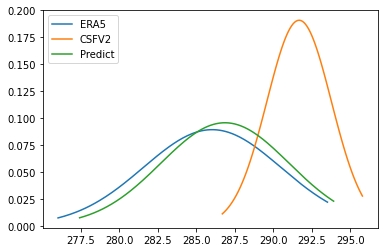

後90天
第1天: 20120830
           Type    ERA5   CSFV2  Predict  Ori_diff  Pre_deff
0      Mean_180  277.91  286.02   278.98     -8.11     -1.07
1       STD_180    3.02    4.47     3.13     -1.45     -0.11
2   Maximum_180  283.47  293.56   284.44    -10.09     -0.97
3   Minimum_180  272.25  276.01   272.97     -3.76     -0.72
4  Skewness_180   -0.04   -0.29    -0.18      0.25      0.14


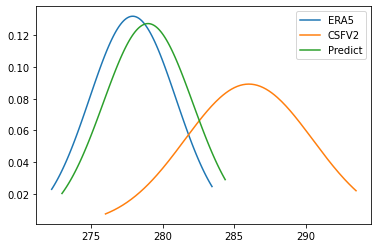

前90天
第916天: 20150303
          Type    ERA5   CSFV2  Predict  Ori_diff  Pre_deff
0      Mean_90  284.04  277.29   283.32      6.75      0.72
1       STD_90    4.16    3.58     4.18      0.58     -0.02
2   Maximum_90  291.67  284.88   290.89      6.79      0.78
3   Minimum_90  274.63  269.23   274.29      5.40      0.34
4  Skewness_90   -0.19   -0.21    -0.22      0.02      0.03


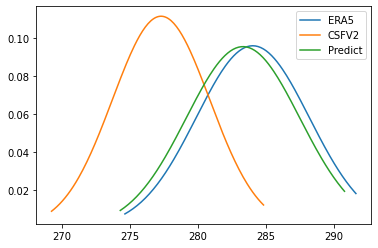

後90天
第916天: 20150303
           Type    ERA5   CSFV2  Predict  Ori_diff  Pre_deff
0      Mean_180  291.23  284.04   290.27      7.19      0.96
1       STD_180    1.76    4.16     1.87     -2.40     -0.11
2   Maximum_180  294.37  291.67   293.44      2.70      0.93
3   Minimum_180  287.90  274.63   286.82     13.27      1.08
4  Skewness_180   -0.11   -0.19    -0.12      0.08      0.01


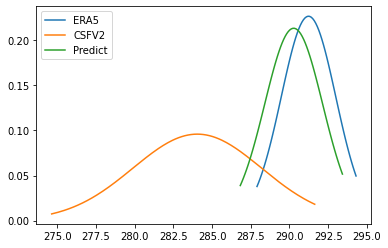

前90天
第1831天: 20170903
          Type    ERA5   CSFV2  Predict  Ori_diff  Pre_deff
0      Mean_90  277.58  286.95   277.19     -9.37      0.39
1       STD_90    3.92    4.32     3.61     -0.40      0.31
2   Maximum_90  285.63  294.27   285.06     -8.64      0.57
3   Minimum_90  268.99  276.86   268.10     -7.87      0.89
4  Skewness_90   -0.19   -0.43    -0.23      0.24      0.04


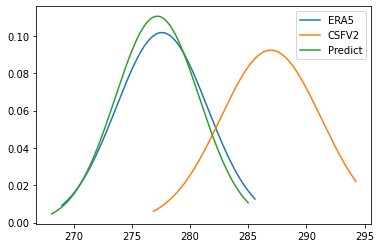

後90天
第1831天: 20170903
           Type    ERA5   CSFV2  Predict  Ori_diff  Pre_deff
0      Mean_180  279.32  277.58   277.85      1.74      1.47
1       STD_180    2.62    3.92     3.18     -1.30     -0.56
2   Maximum_180  283.83  285.63   283.26     -1.80      0.57
3   Minimum_180  273.96  268.99   271.88      4.97      2.08
4  Skewness_180   -0.29   -0.19    -0.25     -0.10     -0.04


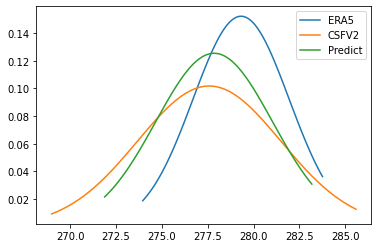

前90天
第2745天: 20200305
          Type    ERA5   CSFV2  Predict  Ori_diff  Pre_deff
0      Mean_90  292.11  282.94   291.22      9.17      0.89
1       STD_90    2.27    4.21     2.27     -1.94      0.00
2   Maximum_90  296.46  290.89   295.81      5.57      0.65
3   Minimum_90  286.64  273.22   285.27     13.42      1.37
4  Skewness_90   -0.30   -0.24    -0.29     -0.06     -0.01


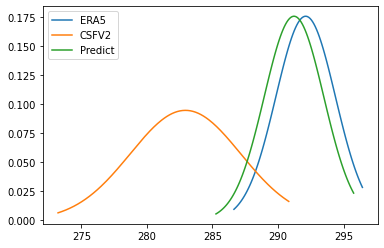

後90天
第2745天: 20200305
           Type    ERA5   CSFV2  Predict  Ori_diff  Pre_deff
0      Mean_180  290.55  292.11   289.55     -1.56      1.00
1       STD_180    1.78    2.27     1.96     -0.49     -0.18
2   Maximum_180  293.77  296.46   292.87     -2.69      0.90
3   Minimum_180  286.86  286.64   285.85      0.22      1.01
4  Skewness_180   -0.17   -0.30    -0.16      0.13     -0.01


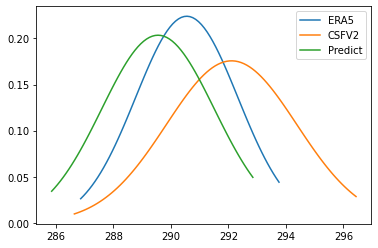

In [92]:
Pic=0
for data in y_predict:
    if Pic == 0 or Pic == int(len(y_predict)/3) or Pic == int(len(y_predict)/3)*2 or Pic == int(len(y_predict)-1):
        print('前90天')
        PDF_average( data, 0, 5, Pic, Time_lists[Pic])

        #後90天
        print('後90天')
        PDF_average(data, 5, 10, Pic, Time_lists[Pic])

    Pic=Pic+1

In [ ]:
#平均作圖PDF
Pic=0
for data in y_predict:
    
    #前90天
    print('前90天')
    PDF_average(data, 0, 5, Pic, Time_lists[Pic])
    
    #後90天
    print('後90天')
    PDF_average(data, 5, 10, Pic, Time_lists[Pic])
    
    Pic=Pic+1